In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier 
from xgboost import plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
import shap
from sklearn.model_selection import cross_val_score, cross_validate

shap.initjs()

In [2]:
### functions for model evaluation
def plot_ROC(y_test, y_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], thresholds0 = roc_curve(1-y_test, y_proba[:, 0])
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], thresholds1 = roc_curve(y_test, y_proba[:, 1])
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize = (5,5))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
def ROC_multiple_models(models, X_train, y_train,X_test, y_test):
    plt.figure(figsize=(8,6))
    for m in models:
        probas = m['model'].fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])  #find ROC for positive class
        roc_auc  = auc(fpr, tpr)  # calculate Area Under the Cuerve
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))  # plot curve

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.show()
    
    
# plot cunfusion matrix
def plot_cm(cm):
    ticks = ['not_snp', 'is snp']
    fig, ax = plt.subplots(figsize=(8,6))
    cm_normed = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    cm_normed = pd.DataFrame(cm_normed, index=ticks, columns=ticks).values*100
    cm = pd.DataFrame(cm, index=ticks, columns=ticks).values

    label = np.array([f"{normed_val:.2f}% \n ({val})" for val, normed_val in zip(cm.flatten(), cm_normed.flatten())])\
        .reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_normed, annot=label, annot_kws={'size': 14}, fmt='', xticklabels=ticks, yticklabels=ticks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# evaluate with metrics on test and training sets
def evaluate_model(model, X_train, X_test, y_test,y_train):
    # make predictions
    y_proba = model.predict_proba(X_test)  # get probalistic prediction
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)

    # evaluate performance - on test set
    print('accuracy on test',accuracy_score(y_test, y_pred))
    print('precision on test',precision_score(y_test, y_pred)) # we want to optimize the precision
    print('recall on test', recall_score(y_test, y_pred))
    print()

    # evaluate performance - on training set
    y_pred_train = model.predict(X_train)
    cm_train = confusion_matrix(y_train,y_pred_train)
    print('accuracy on train',accuracy_score(y_train, y_pred_train))
    print('precision on train',precision_score(y_train, y_pred_train)) # we want to optimize the precision
    print('recall on train',recall_score(y_train, y_pred_train))

    plot_cm(cm)  # plot confusion matrix on test set
    plot_cm(cm_train)  # plot confusion matrix on training set
    plot_ROC(y_test, y_proba)  # plot ROC curve
    print(pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values( #print feature importance
        by = 'importance', ascending = False))
    
    # if model is XGBoost save booster tree and feature importance
    if type(model) == XGBClassifier:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
        plot_tree(model.get_booster(),num_trees=0,ax=ax)
        plt.savefig("xgboos_tree.jpg",dpi=300)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        plot_importance(model.get_booster(),importance_type='gain',ax=ax)   
        plt.savefig("xgboos_feature_importance.jpg",dpi=300)
        plt.show()

# initialize models
model_rf = RandomForestClassifier(n_jobs = -1,  n_estimators=100, random_state=123)
model_gb = GradientBoostingClassifier(max_depth = 6,random_state = 123, n_estimators=100)
model_ab = AdaBoostClassifier()
model_xgb = XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=888, n_jobs=-1)
model_lr = LogisticRegression(max_iter = 2000)

models = [
    { 'label' : 'GradientBoosting', 'model': model_gb },
    { 'label' : 'Random Forest', 'model': model_rf },
    { 'label' : 'AdaBoost', 'model': model_ab },
    { 'label' : 'XGBoost', 'model': model_xgb },
    { 'label' : 'Logistic Regression', 'model': model_lr }
]


## Load and process data

In [25]:
# get the filtered tables
def get_filtered(df, min_mutation_cb_to_filter,min_mutation_umis, min_total_umis):
    """filtering function for aggregated tables"""
    mutation_umi_counts = df['total mutation umi count']
    total_umi_count = mutation_umi_counts + df['unmutated multi reads'] + df['unmutated single reads']

    cond_1 = (df['count of mutated cell barcodes'] >= min_mutation_cb_to_filter)
    cond_2 = ((mutation_umi_counts >= min_mutation_umis) & (total_umi_count >= min_total_umis))
    return df[cond_1 & cond_2]
              

# remove overlaps between snp and edit sites
def drop_ifs(df):
    """remove positions which appear in both editing and snp sites"""
    idx = df[((df['is_editing_non_rep'] == 1) | (df['is_editing_rep'] == 1)) & (df['is_snp'] == 1)].index
    print("number of positin with snp and editing overlap to remove: %d." %len(idx))
    return df.drop(idx)


### load dataset

adipose_dir = '/home/eligol/Documents/01_WIS/01_Rarevar/data/outputs/statistics_output/human_adipose/'
adipose_df = pd.read_csv(os.path.join(adipose_dir ,'aggregated_intersect.tsv'), sep = '\t')
# adipose_df = get_filtered(adipose_df, 5, 1)
# adipose_df = drop_ifs(adipose_df)

embryo_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/outputs/statistics_output/human_RSS9450/aggregated_intersect.tsv'
embryo_df = pd.read_csv(embryo_path, sep = '\t')
embryo_df = get_filtered(embryo_df,5, 10, 20)
# embryo_df = drop_ifs(embryo_df)

KeyError: 'total mutation umi count'

In [27]:
embryo_df['is_snp'].value_counts()

0    2127382
1     245536
2       6300
3       1796
4        223
5         38
6          5
7          4
9          1
Name: is_snp, dtype: int64

## Define parameters and dataset for model training

In [12]:
WITH_REF_COLS = True  #flag to keep ref base columns
TO_SCALE = False # flag to scale the data
non_ref_percent_snp_thresh = 10  # threshol for column 'perent of non ref total reads' for more confident snp sites 

df = embryo_df

In [19]:
df['is_editing_rep'].value_counts()

0    63993
1      250
Name: is_editing_rep, dtype: int64

In [5]:
# df_open = pd.read_csv("/home/eligol/Documents/01_WIS/01_Rarevar/outputs/statistics_output/human_RSS9451/merged_mutated_unmutated_no_agg.tsv", sep='\t')
# df_open = pd.read_csv("/home/eligol/Documents/01_WIS/01_Rarevar/data/raw_Stats_files/human_RSS9451/raw_stats.tsv", sep='\t')
# df_open 

## set data for training

In [5]:
def set_data_with_snp_thresh(non_ref_percent_snp_thresh):
    # first notate snps with more than 10% non ref total reads. These are sites we can be more confident for beeing snp, rather than less than 10% of non ref mutation
    df['is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)] = 0  #initialize column
    idx_snp_gt_X = df[(df['is_snp'] == 1) & (df['percent of non ref total umis'] >= non_ref_percent_snp_thresh)].index #find the sites with more tahn 10% mutation
    df.loc[idx_snp_gt_X, 'is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)] = 1  # assign to columns


    #drop unused columns
    df_numeric = df.drop(['#Chromosome','start','end','reference base','position',  
                                      'strand','aggregated cell barcodes'], axis = 1)
    if TO_SCALE:  # scale the df (not binary reference base columns)
        df_numeric = pd.DataFrame(StandardScaler().fit_transform(df_numeric),  
                                        index = df_numeric.index, columns = df_numeric.columns)
    if WITH_REF_COLS:  # convert ref columns to dummies and add to ddf
        # get dummies for reference bases
        dummies = pd.get_dummies(df['reference base'],prefix = 'refbase')
        # concat scaled df and dummies columns
        df_numeric = pd.concat([df_numeric,dummies], join = 'inner',axis = 1)
    return df, df_numeric

# Classification tasks

## SNP soft classifier

### search the best non_ref_percent_snp_thresh

In [6]:
def set_snp_non_ref_thresh(non_ref_percent_snp_thresh):
    df, df_numeric = set_data_with_snp_thresh(non_ref_percent_snp_thresh)
    # make the X features
    X = df_numeric.drop(['is_snp','is_editing_rep','is_editing_non_rep','is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)],axis=1)  # set X to be all the mutation data

    # make label column
    y = df['is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)]

    #columns which were found beneficial to drop. check this out again
    # X = X.drop(['percent of non ref mutated reads', 'unmutated single reads','count of unmutated cell barcodes','mixed reads'], axis = 1)

    print("y counts:")
    print(y.value_counts())
    print()
    return X, y
    
def train_snp_clf(model, non_ref_percent_snp_thresh):
    X, y = set_snp_non_ref_thresh(non_ref_percent_snp_thresh)
    scores = cross_validate(model, X, y,scoring='roc_auc',n_jobs = -1, cv=5, return_train_score=True)
    print("SNP classifier cross validation TEST scores with non_ref_percent_snp_thresh of {}".format(non_ref_percent_snp_thresh), scores['test_score'])
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores['test_score'].mean(), scores['test_score'].std()))
    print("SNP classifier cross validation TRAIN scores with non_ref_percent_snp_thresh of {}".format(non_ref_percent_snp_thresh), scores['train_score'])
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores['train_score'].mean(), scores['train_score'].std()))

In [11]:
# model = XGBClassifier(n_estimators=100, objective='binary:logistic',n_jobs=-1, subsample= 0.8, random_state=123,
#                       reg_lambda= 0.0001, reg_alpha= 0.0001, min_child_weight= 5, max_depth= 4, 
#                       learning_rate= 0.1, gamma= 0.1, colsample_bytree= 1.0)
model = XGBClassifier(n_jobs=-1,random_state=123)

for i in [0,30,40,50]:
    print("\n####")
    print("snp_non_ref_thresh is: ",i)
    train_snp_clf(model,i)
    df= df.drop('is_snp_umi_mut_gt_{}'.format(i), axis=1)


####
snp_non_ref_thresh is:  0
y counts:
0    45424
1    18819
Name: is_snp_umi_mut_gt_0, dtype: int64

SNP classifier cross validation TEST scores with non_ref_percent_snp_thresh of 0 [0.96713206 0.96555239 0.96511226 0.97117945 0.96759539]
0.97 accuracy with a standard deviation of 0.00
SNP classifier cross validation TRAIN scores with non_ref_percent_snp_thresh of 0 [0.98688565 0.98685325 0.98686472 0.98667586 0.98653693]
0.99 accuracy with a standard deviation of 0.00

####
snp_non_ref_thresh is:  30
y counts:
0    46236
1    18007
Name: is_snp_umi_mut_gt_30, dtype: int64

SNP classifier cross validation TEST scores with non_ref_percent_snp_thresh of 30 [0.98272612 0.97838264 0.98339357 0.98112781 0.98259731]
0.98 accuracy with a standard deviation of 0.00
SNP classifier cross validation TRAIN scores with non_ref_percent_snp_thresh of 30 [0.99199164 0.99236044 0.99184411 0.99233965 0.99178528]
0.99 accuracy with a standard deviation of 0.00

####
snp_non_ref_thresh is:  40
y count

### Build a model with the best snp_non_ref threshold

y counts:
0    47460
1    16783
Name: is_snp_umi_mut_gt_40, dtype: int64

accuracy on test 0.9456767063584715
precision on test 0.8731406118439518
recall on test 0.9267202859696158

accuracy on train 0.9667081760516791
precision on train 0.918183765260227
recall on train 0.9579174735587666


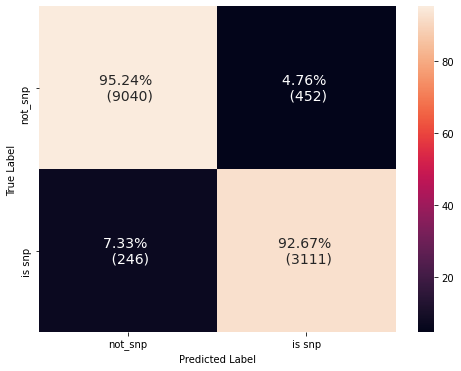

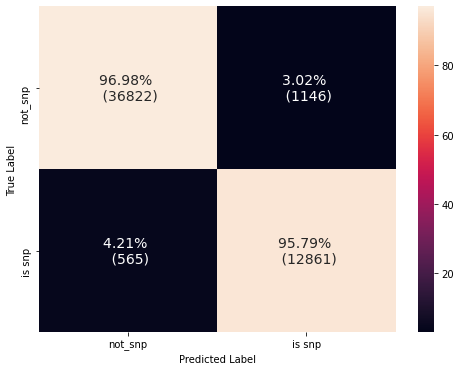

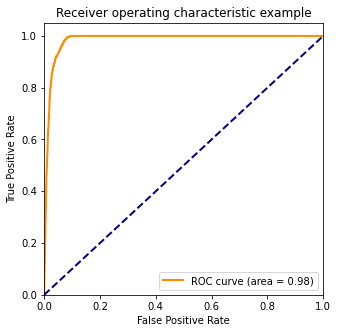

                                        importance
percent of non ref total umis             0.566441
refbase_a                                 0.119523
R->A multi reads                          0.043267
R->A single reads                         0.028740
R->C single reads                         0.023879
R->G single reads                         0.023461
R->T multi reads                          0.021033
refbase_c                                 0.018893
R->C multi reads                          0.015962
R->T single reads                         0.012407
R->G multi reads                          0.012037
unmutated multi reads                     0.010507
unmutated single reads                    0.010498
refbase_g                                 0.010339
count of unmutated cell barcodes          0.010213
refbase_t                                 0.009732
percent of non ref mutated umis           0.008175
total umi counts 1 cells                  0.007660
count of mutated cell barcodes 

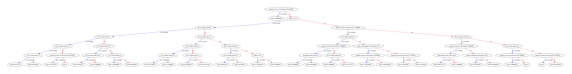

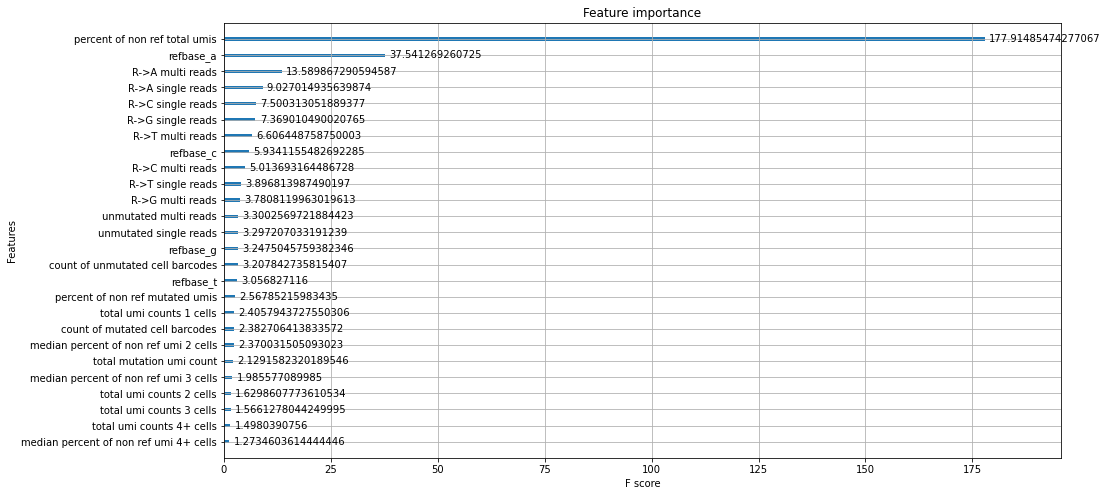

In [7]:
X, y = set_snp_non_ref_thresh(40)
#split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)
# train and analyze
# ROC_multiple_models(models, X_train, y_train,X_test, y_test)
# this is currently the best modelafter after parameter random search
model = XGBClassifiermodel = XGBClassifier(n_jobs=-1,random_state=123,verbosity=0)

model.fit(X_train, y_train) # fit the model to the data
evaluate_model(model, X_train, X_test, y_test, y_train)

#### Analyze the mistake instances -

In [15]:
# look into the test set
y_pred = model.predict(X_test)
true_values = y_test
predicted_values = y_pred

idx = X_test[(true_values == 1) & (predicted_values == 0)].index
X_test.loc[idx,:]  #normalizes
df.loc[idx,:]  # original

#Chromosome      start        end                    position  \
800175        chr15   91022573   91022574   chr15:91022573-91022574,+   
1672054        chr4   30979016   30979017    chr4:30979016-30979017,+   
892067        chr16   84488689   84488690   chr16:84488689-84488690,-   
2375375        chrX  136210922  136210923  chrX:136210922-136210923,+   
1853260        chr5  157787425  157787426  chr5:157787425-157787426,-   
...             ...        ...        ...                         ...   
1145672       chr19   38648307   38648308   chr19:38648307-38648308,+   
1294052        chr2  148030143  148030144  chr2:148030143-148030144,+   
1362012        chr2  232769374  232769375  chr2:232769374-232769375,+   
1767698        chr5   32391921   32391922    chr5:32391921-32391922,-   
1563913        chr3   77176745   77176746    chr3:77176745-77176746,+   

         percent of non ref total umis strand  \
800175                           52.38      +   
1672054                          48.00      +   
892067                           70.83      -   
2375375                         100.00      +   
1853260                          47.62      -   
...                                ...    ...   
1145672                          43.48      +   
1294052                          54.84      +   
1362012                          52.73      +   
1767698                          62.07      -   
1563913                          52.38      +   

         count of unmutated cell barcodes  count of mutated cell barcodes  \
800175                                8.0                              11   
1672054                              25.0                              24   
892067                                7.0                              17   
2375375                               0.0                             152   
1853260                              22.0                              20   
...                                   ...                             ...   
1145672                              12.0                              10   
1294052                              13.0                              17   
1362012                              26.0                              29   
1767698                              11.0                              18   
1563913                              10.0                              11   

         percent of non ref mutated umis reference base  R->A multi reads  \
800175                            100.00              a                 0   
1672054                           100.00              a                 0   
892067                            100.00              g                 1   
2375375                           100.00              g                13   
1853260                           100.00              a                 0   
...                                  ...            ...               ...   
1145672                            90.91              a                 0   
1294052                           100.00              a                 0   
1362012                           100.00              a                 0   
1767698                           100.00              a                 0   
1563913                           100.00              a                 0   

         R->T multi reads  R->G multi reads  R->C multi reads  \
800175                  0                 1                 0   
1672054                 0                10                 0   
892067                  0                 0                 0   
2375375                 0                 0                 0   
1853260                 0                 7                 0   
...                   ...               ...               ...   
1145672                 0                 4                 0   
1294052                 0                 8                 0   
1362012                 0                10                 0   
1767698                 0                 

# SHAP

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


In [11]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[1,:])

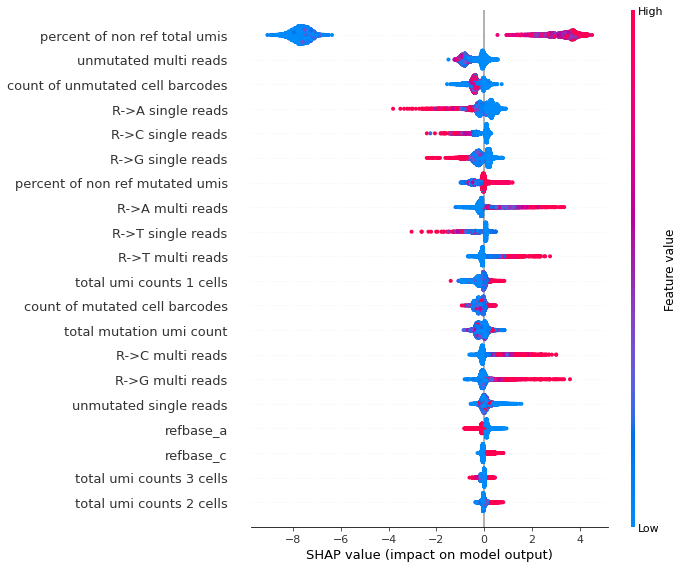

In [29]:
shap.summary_plot(shap_values, X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


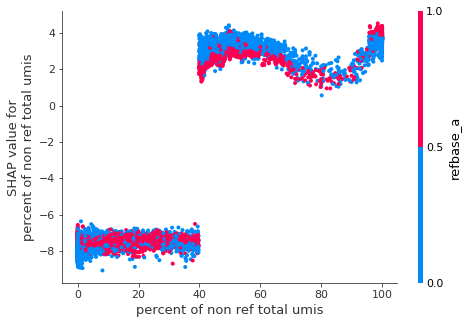

In [36]:
shap.dependence_plot("percent of non ref total umis", shap_values, X_test, interaction_index="refbase_a")

In [ ]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


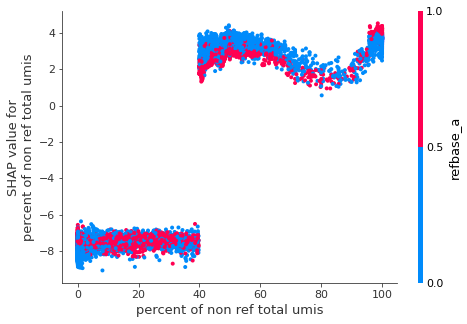

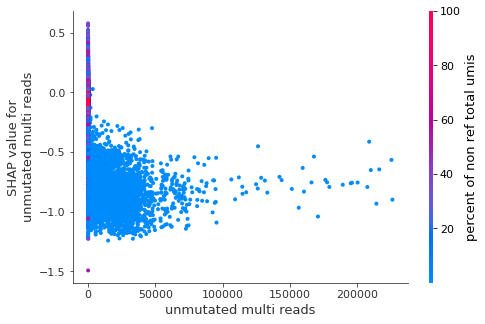

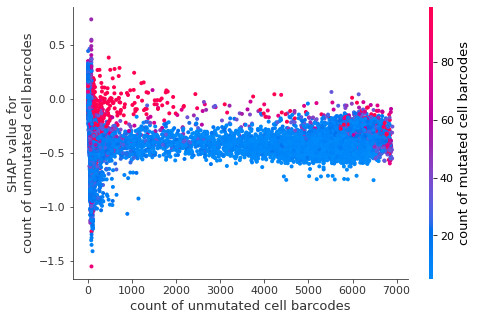

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


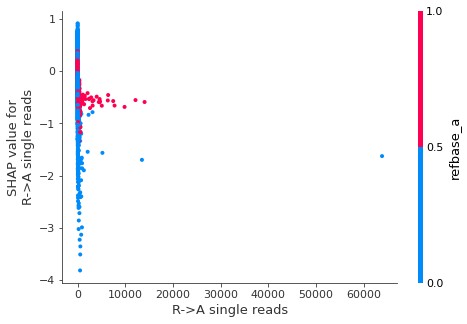

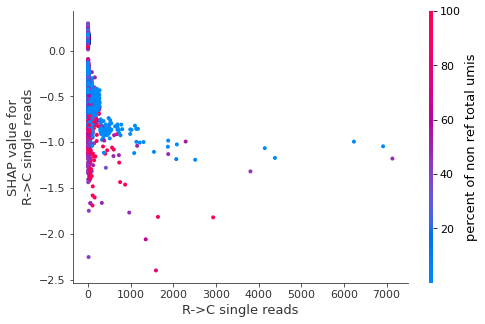

In [37]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

accuracy on test 0.9111893946416983
precision on test 0.8483701366982124
recall on test 0.7714668196595907

accuracy on train 0.9111641597330058
precision on train 0.8404955279119976
recall on train 0.7818207899015014


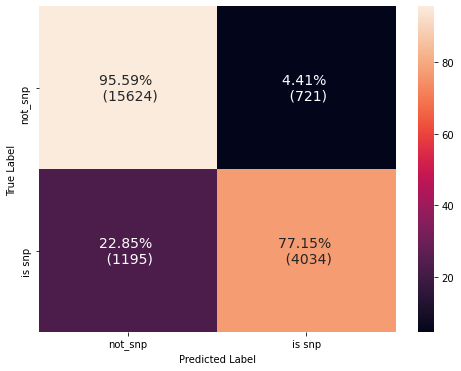

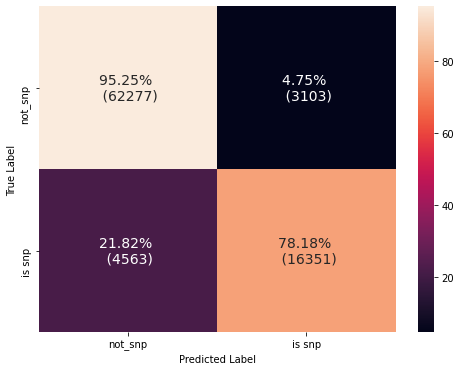

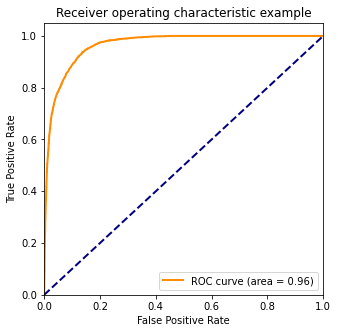

                                        importance
percent of non ref total reads            0.388372
R->G single reads                         0.129190
refbase_a                                 0.076662
R->A multi reads                          0.055538
R->A single reads                         0.047522
R->C single reads                         0.040622
R->T multi reads                          0.035231
R->C multi reads                          0.033388
unmutated multi reads                     0.029589
refbase_t                                 0.024279
count of mutated cell barcodes            0.022004
total umi counts 4+ cells                 0.021826
refbase_c                                 0.020637
R->T single reads                         0.019952
refbase_g                                 0.016462
count of unmutated cell barcodes          0.011812
percent of non ref mutated reads          0.010824
R->G multi reads                          0.010512
unmutated single reads         

In [64]:
# ANALYSIS FROM 12/5/21
#split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)
# train and analyze
ROC_multiple_models(models, X_train, y_train,X_test, y_test)
# this is currently the best modelafter after parameter random search
model = XGBClassifier(n_estimators=100, objective='binary:logistic',n_jobs=-1, subsample= 0.8, random_state=123,
                      reg_lambda= 0.0001, reg_alpha= 0.0001, min_child_weight= 5, max_depth= 4, 
                      learning_rate= 0.1, gamma= 0.1, colsample_bytree= 1.0)


model.fit(X_train, y_train) # fit the model to the data
evaluate_model(model, X_train, X_test, y_test, y_train)

### save model to file

In [17]:
# train again on all the data and save the model to file for use in pipeline

# this is currently the best modelafter after parameter random search
moedl = XGBClassifier(n_estimators=100, objective='binary:logistic',n_jobs=-1, subsample= 0.8, random_state=123,
                      reg_lambda= 0.0001, reg_alpha= 0.0001, min_child_weight= 5, max_depth= 4, 
                      learning_rate= 0.1, gamma= 0.1, colsample_bytree= 1.0)
model.fit(X, y) # fit the model to the data
# evaluate_model(model, X, X, y, y)
dump(model, '/home/eligol/Documents/01_WIS/01_Rarevar/data/trained_models/snp_classifier.joblib') 

['/home/eligol/Documents/01_WIS/01_Rarevar/data/trained_models/snp_classifier.joblib']

### load the model and make predictions on new data

In [19]:
def preprocess(df):
    # preprocess data
    df_numeric_test = df.drop(['#Chromosome', 'start', 'end', 'reference base', 'position',
                                    'strand', 'aggregated cell barcodes', 'is_snp', 'is_editing_rep',
                                    'is_editing_non_rep'], axis=1)
    # optianal columns to drop. may change in future
    # df_numeric_test = df_numeric_test.drop(
    #     ['percent of non ref mutated reads', 'unmutated single reads', 'count of unmutated cell barcodes',
    #      'mixed reads'], axis=1)
    # convert ref columns to dummies
    dummies = pd.get_dummies(df['reference base'], prefix='refbase')

    # concat scaled df and dummies columns
    df_numeric_test = pd.concat([df_numeric_test, dummies], join='inner', axis=1)
    return df_numeric_test


def get_filtered(df, min_mutation_cb_to_filter,min_mutation_umis, min_total_umis):
    """filtering function for aggregated tables"""
    mutation_umi_counts = df['total mutation umi count']
    total_umi_count = mutation_umi_counts + df['unmutated multi reads'] + df['unmutated single reads']

    cond_1 = (df['count of mutated cell barcodes'] >= min_mutation_cb_to_filter)
    cond_2 = ((mutation_umi_counts >= min_mutation_umis) & (total_umi_count >= min_total_umis))
    return df[cond_1 & cond_2]

number of rows before snp filtering:  130517
number of overlaps between the table and SNP database: 24891
number of positions classified as SNP by the classifier: 24590
number of overlaps between classifier and database: 19418
number of new assumed snp sites: 5172

dropping SNP from database and assumed by classifier.
number of rows in the table now: 100454


In [ ]:
df_test = df

## XGBoost parameter random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.01, 0.1, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate':[0.01, 0.1, 1],
        'reg_alpha' : [0, 1e-2,1e-3,1e-4,1e-5],
        'reg_lambda' : [0, 1e-2,1e-3,1e-4,1e-5]
        }
xgb = XGBClassifier(learning_rate=0.1, n_estimators=500, objective='binary:logistic',n_jobs=-1,)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1001 )
random_search.fit(X_train, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

In [ ]:
evaluate_model(random_search.best_estimator_, X_train, X_test, y_test, y_train)

# Classification - no SNP data

In [ ]:
# DATA 1
# use all data, but leave edit as 1 and all the rest as 0
X = df_numeric  # set X to be all the mutation data
y = df['label'].copy()
y[snp_df.index] = 0 #1 labels are snp


In [50]:
# DATA 2
# drop snp positions
# no_snp_idx = df[df['label'] != 2].index
# X = df_numeric.loc[no_snp_idx,:]  # set X to be all the mutation data
# y = df.loc[no_snp_idx, 'label'].copy()

In [ ]:
# over sampling
# ros = RandomOverSampler(sampling_strategy=1,random_state=0,shrinkage=0)
# X_resampled, y_resampled = ros.fit_resample(X, y)
# down sampling
ros = RandomUnderSampler(random_state=0,sampling_strategy=0.25)
X_resampled, y_resampled = ros.fit_resample(X, y)

X=X_resampled
y=y_resampled

In [ ]:
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)
model = model_xgb
model.fit(X_train, y_train) # fit the model to the data. This is essencially the 'learning'

In [ ]:
# train and evaluate
ROC_multiple_models(models, X_train,y_train,X_test,y_test)
evaluate_model(model, X_train, X_test, y_test, y_train)

#I THINK WE CARE MOST ABOUT FALSE NEGATIVES. SO WE 

In [65]:
print(random_search.best_score_)
print(random_search.best_params_)

0.951188196321161
{'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 6, 'gamma': 5, 'colsample_bytree': 0.8}


In [54]:
model.feature_importances_
# print(pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values( #print feature importance
#         by = 'importance', ascending = False))

array([0.01672326, 0.01520788, 0.00917328, 0.01504261, 0.01421987,
       0.00861088, 0.01107866, 0.0078805 , 0.01114173, 0.01418397,
       0.01461297, 0.01163295, 0.01687688, 0.01807128, 0.01676401,
       0.57503325, 0.03768875, 0.05423748, 0.13181977], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

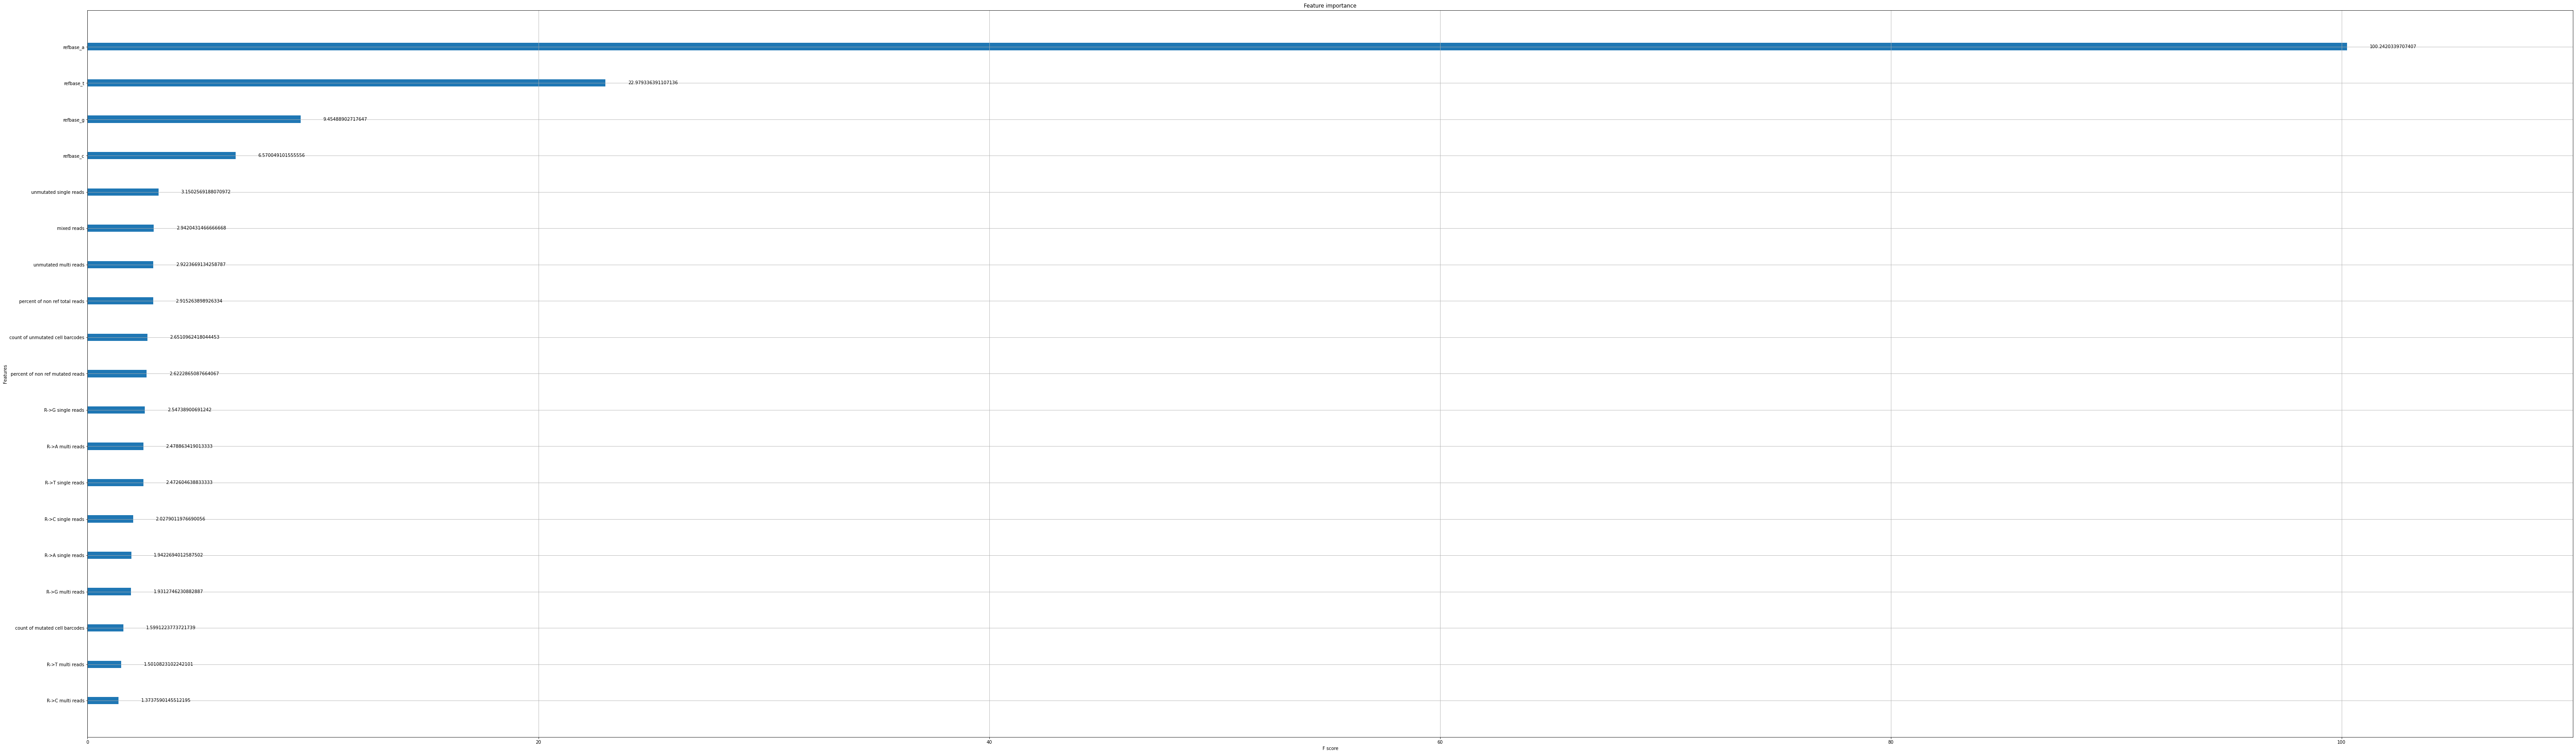

In [59]:
fig, axs = plt.subplots(1,1,figsize = (100,30))
plot_importance(model, importance_type='gain',ax= axs)
# plt.savefig('xgboost.png')


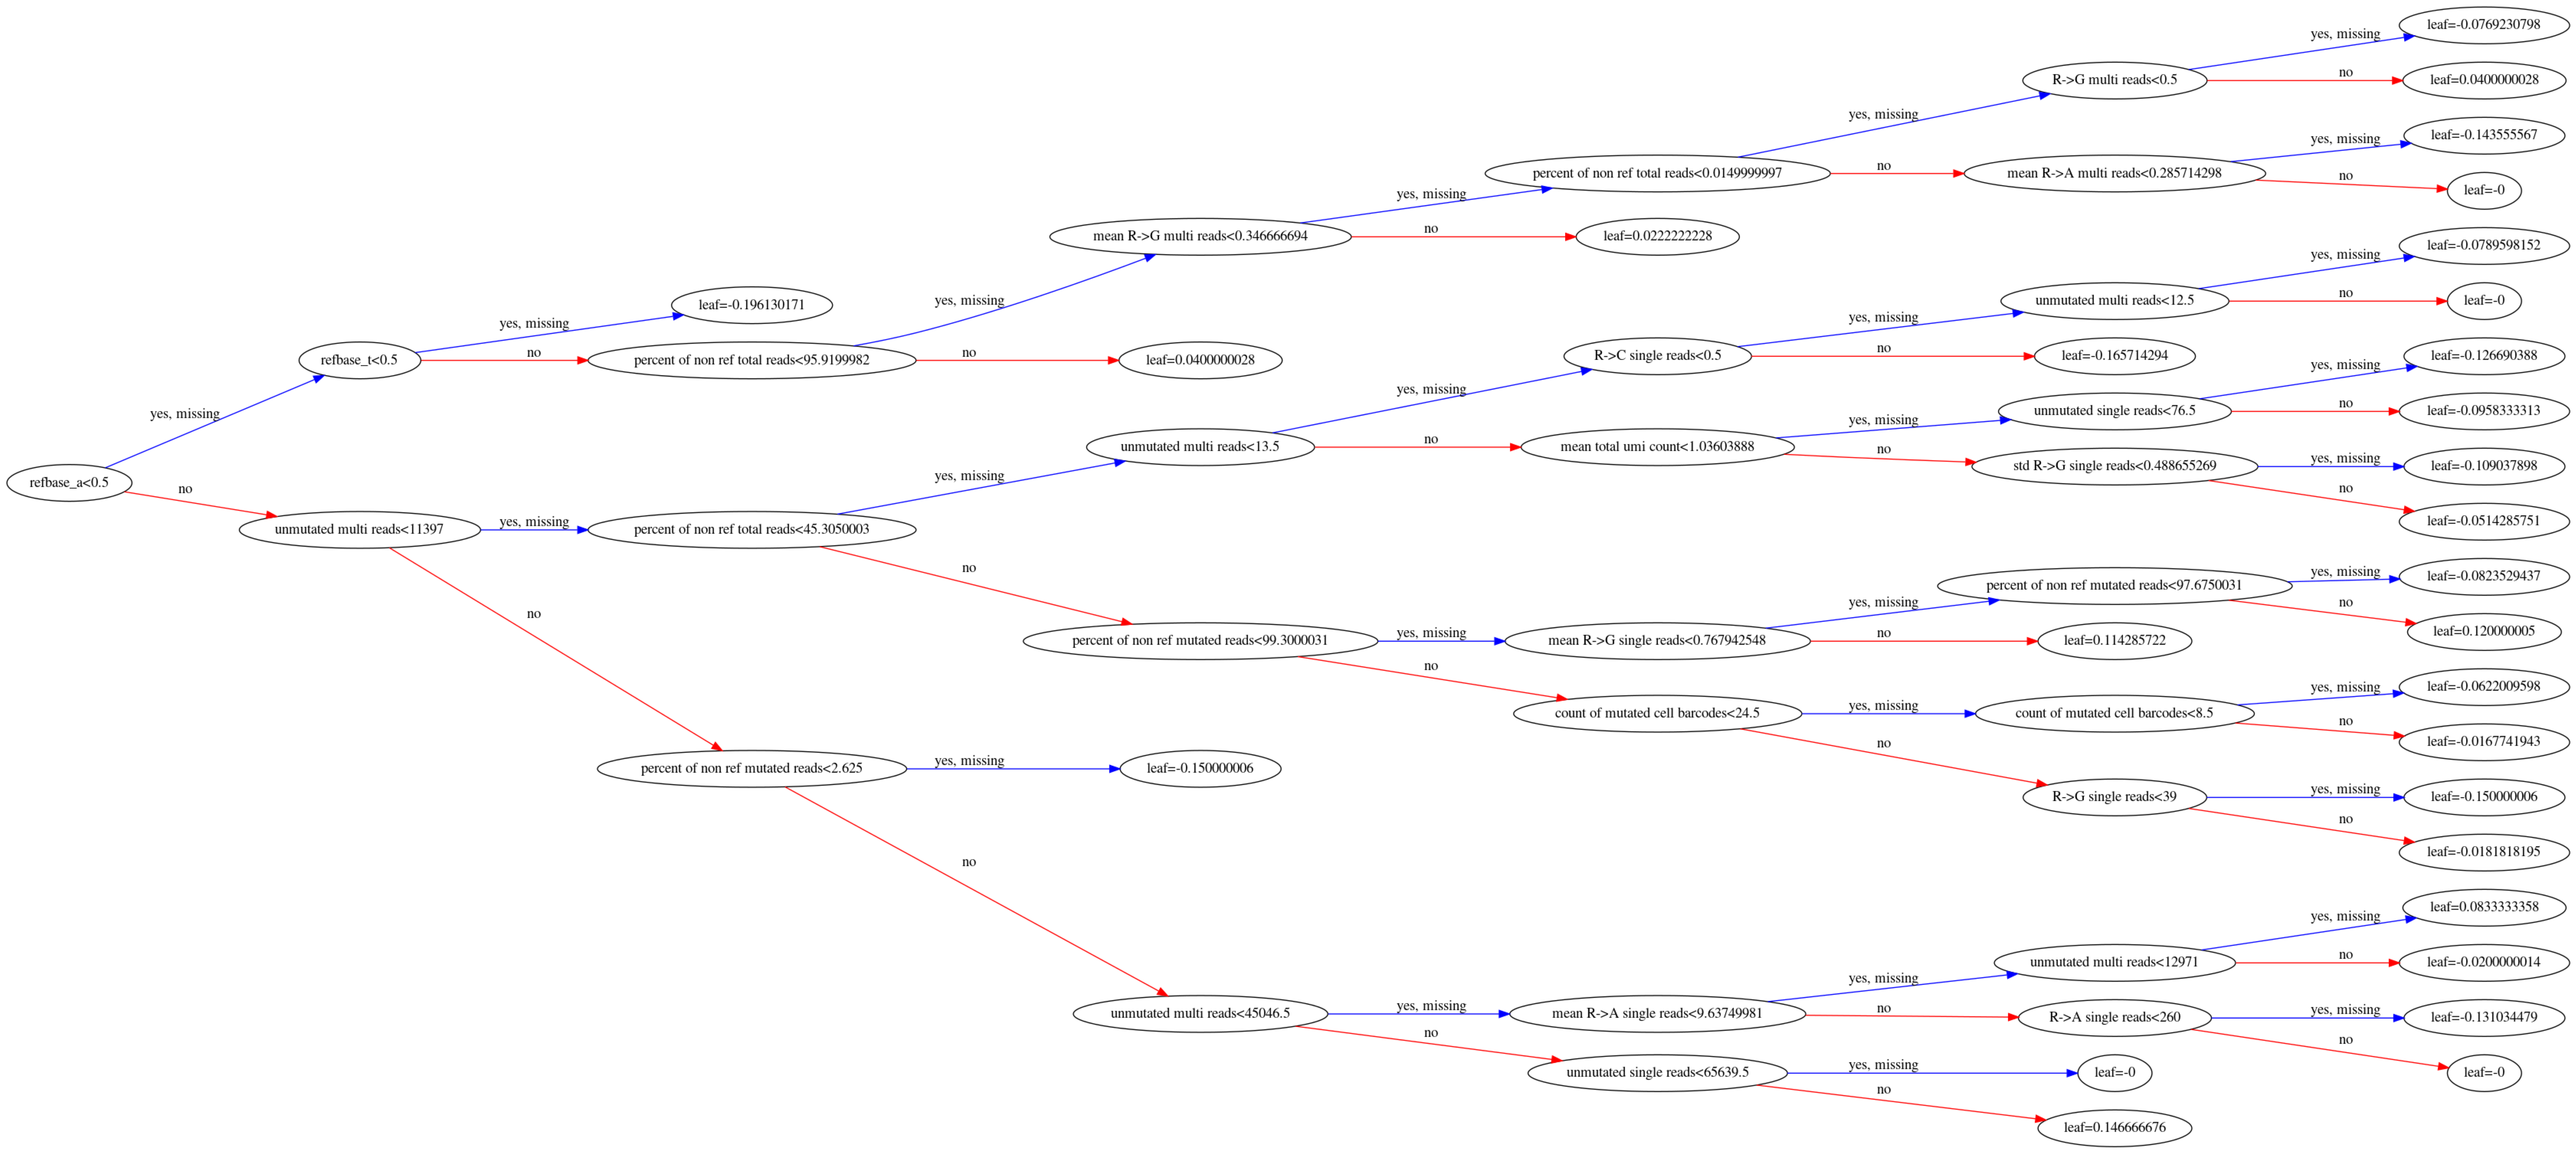

In [56]:
fig, axs = plt.subplots(1,1,figsize = (200,50))
plot_tree(model,num_trees=0,ax= axs, rankdir='LR')
plt.savefig('xgboost.png')

## train two datasets

In [235]:
# set test set
df_test = embryo_df

snp_df_test = df_test[df_test['is_snp'] == 1]  #create separate df_test for SNP
pos_df_test = df_test[(df_test['is_editing_rep'] == 1) | (df_test['is_editing_non_rep'] == 1)]  # set editing sites as positive label
neg_df_test = df_test[(df_test['is_editing_rep'] != 1) & (df_test['is_editing_non_rep'] != 1) & (df_test['is_snp'] != 1)]  # otherwise set as negative label

# set the labels for all samples in df_test
df_test.loc[snp_df_test.index, 'label'] = 2
df_test.loc[pos_df_test.index, 'label'] = 1
df_test.loc[neg_df_test.index, 'label'] = 0

df_test = df_test  # set df_test to analyze
#drop unused columns
df_test_numeric = df_test.drop(['#Chromosome','start','end','reference base','position',  
                                  'strand','aggregated cell barcodes','is_snp','is_editing_rep',
                                  'is_editing_non_rep','label'], axis = 1)
# get dummies for reference bases
dummies = pd.get_dummies(df_test['reference base'],prefix = 'refbase')
# scale the df_test (not binary reference base columns)
# df_test_numeric = pd.DataFrame(StandardScaler().fit_transform(df_test_numeric),  
#                                 index = df_test_numeric.index, columns = df_test_numeric.columns)
# concat scaled df_test and dummies columns
df_test_numeric = pd.concat([df_test_numeric,dummies], join = 'inner',axis = 1)
df_test_numeric

percent of non ref total reads  count of unmutated cell barcodes  \
0                                 40.83                                70   
15                                12.77                                41   
16                                86.96                                 3   
46                                 1.44                               397   
47                                 2.39                               393   
...                                 ...                               ...   
2387225                           35.71                                 9   
2387226                           91.67                                 1   
2387228                           75.00                                 3   
2387334                           13.89                                30   
2387340                           14.06                               110   

         count of mutated cell barcodes  percent of non ref mutated reads  \
0                                    49                             98.00   
15                                    6                            100.00   
16                                   20                            100.00   
46                                    6                            100.00   
47                                   10                             90.91   
...                                 ...                               ...   
2387225                               5                            100.00   
2387226                              11                            100.00   
2387228                               9                            100.00   
2387334                               5                            100.00   
2387340                              18                            100.00   

         R->A multi reads  R->T multi reads  R->G multi reads  \
0                       0                 2                 0   
15                      0                 0                 0   
16                      0                 3                 0   
46                      0                 0                 0   
47                      0                 0                 0   
...                   ...               ...               ...   
2387225                 0                 0                 1   
2387226                 1                 0                 0   
2387228                 0                 0                 4   
2387334                 0                 0                 0   
2387340                 3                 0                 0   

         R->C multi reads  R->A single reads  R->T single reads  \
0                       0                  0                 47   
15                      2                  0                  0   
16                      0                  0                 17   
46                      0                  2                  0   
47                      0                  4                  1   
...                   ...                ...                ...   
2387225                 0                  0                  0   
2387226                 0                 10                  0   
2387228                 0                  0                  0   
2387334                 0                  3                  0   
2387340                 0                 15                  0   

         R->G single reads  R->C single reads  mixed reads  \
0                        0                  1            0   
15                       0                  4            0   
16                       0                  0            0   
46                       3                  1            0   
47                       4                  2            0   
...                    ...                ...          ...   
2387225                  4                  0            0   
2387226                  0                  0            0   
2387228        

In [238]:
# prepare the data
X_test = df_test_numeric  # set X to be all the mutation data
y_test = df_test['label'].copy()
y_test[pos_df_test.index] = 0 #0 labels are non editing + editing sites
y_test[snp_df_test.index] = 1 #1 labels are snp

In [245]:
y.value_counts()

0.0    105680
1.0     25141
Name: label, dtype: int64

accuracy on test 0.8922907083716651
precision on test 0.8685536099784121
recall on test 0.6687474605695711

accuracy on train 0.9277103828895973
precision on train 0.8450065992080951
recall on train 0.7639712024183605


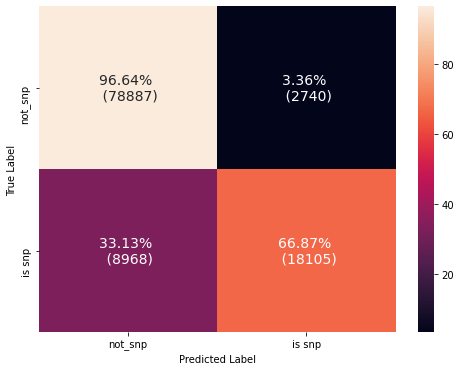

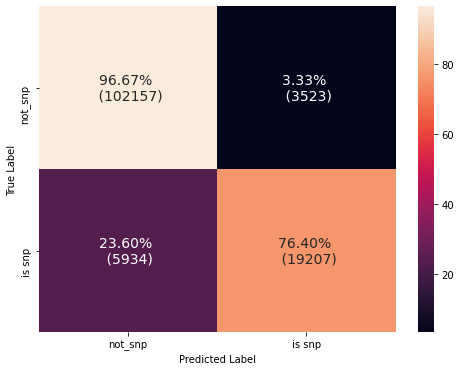

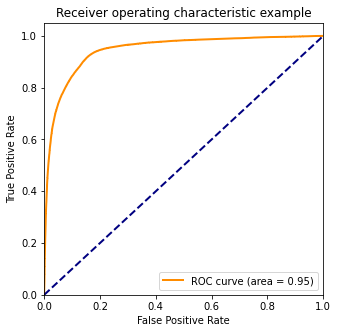

                                  importance
refbase_a                           0.511226
percent of non ref total reads      0.278606
R->G single reads                   0.043896
R->G multi reads                    0.019790
R->A single reads                   0.016799
refbase_t                           0.016655
R->A multi reads                    0.014584
R->T multi reads                    0.013384
refbase_g                           0.010004
unmutated single reads              0.009697
R->C single reads                   0.009667
unmutated multi reads               0.008913
count of mutated cell barcodes      0.008818
R->C multi reads                    0.008610
R->T single reads                   0.007630
refbase_c                           0.006690
count of unmutated cell barcodes    0.006462
percent of non ref mutated reads    0.004482
mixed reads                         0.004086


In [246]:
model = model_xgb  # choose one model
model.fit(X, y) # fit the model to the data. This is essencially the 'learning'

evaluate_model(model, X, X_test, y_test, y)


In [16]:
model.estimators_.shape

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

In [17]:
model.get_booster()

In [ ]:
percent of non ref total umis             0.538156
R->G single reads                         0.069128
refbase_a                                 0.066986
R->A multi reads            

In [10]:
# Get the tree number 42
sub_tree_42 = model.estimators_[99, 0]

# Visualization. Install graphviz in your system
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())
with open("a.png", "wb") as png:
    png.write(graph.create_png()) 

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

### Plot histgrams of features

In [23]:
snp_df = df[df['is_snp'] == 1]  #create separate df for SNP
pos_df = df[(df['is_editing_rep'] == 1) | (df['is_editing_non_rep'] == 1)]  # set editing sites as positive label
neg_df = df[(df['is_editing_rep'] != 1) & (df['is_editing_non_rep'] != 1) & (df['is_snp'] != 1)]  # otherwise set as negative label

# set the labels for all samples in df
df.loc[snp_df.index, 'label'] = 2
df.loc[pos_df.index, 'label'] = 1
df.loc[neg_df.index, 'label'] = 0

embryo_snp = embryo_df[embryo_df['is_snp'] == 1]  #create separate df for SNP
embryo_pos = embryo_df[(embryo_df['is_editing_rep'] == 1) | (embryo_df['is_editing_non_rep'] == 1)]
embryo_neg = embryo_df[(embryo_df['is_editing_rep'] != 1) & (embryo_df['is_editing_non_rep'] != 1) & (embryo_df['is_snp'] != 1)]

adipose_snp = adipose_df[adipose_df['is_snp'] == 1]  #create separate df for SNP
adipose_pos = adipose_df[(adipose_df['is_editing_rep'] == 1) | (adipose_df['is_editing_non_rep'] == 1)]
adipose_neg = adipose_df[(adipose_df['is_editing_rep'] != 1) & (adipose_df['is_editing_non_rep'] != 1) & (adipose_df['is_snp'] != 1)]

In [57]:
'a'.startswith(('a','b'))

True

In [67]:
import random
from math import ceil
import cliffsDelta

def plot_histograms(df1,df2, legend):
    # drop columns we don't visualize
    cols_to_drop = ['#Chromosome', 'start', 'end', 'position','strand',
       'aggregated cell barcodes','is_snp', 'is_editing_rep',
       'is_editing_non_rep']
    df1.drop(cols_to_drop,axis=1,inplace=True)
    df2.drop(cols_to_drop,axis=1,inplace=True)
    
    # make plt object
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))
    axs = axs.reshape(-1)
    
    for i, col in enumerate(df1.columns):
        if col == 'reference base':
            axs[4].set_title(col)
            axs[4].hist(df1[col], bins = 30,color = 'springgreen', density=True)
            axs[4].hist(df2[col], bins = 30, alpha = 0.3, color  = 'blue', density=True)
            axs[4].legend(legend)
          
        elif col.startswith(('percent','median')):
            cliffD = cliffsDelta.cliffsDelta(df1[col],df2[col])[0]     
            cliffD_label = cliffsDelta.cliffsDelta(df1[col],df2[col])[1]
            axs[i].set_title(col + "\ncliff's D: %.2f (%s)" %(cliffD, cliffD_label))
            bins = [2 ** n for n in list(range(0, ceil(np.log2(max(df1[col]))) + 1))]
            axs[i].hist(df1[col], bins=bins, color = 'springgreen', density=True)
            bins = [2 ** n for n in list(range(0, ceil(np.log2(max(df2[col]))) + 1))]
            axs[i].hist(df2[col], bins=bins, color  = 'blue', density=True, alpha = 0.3)
            axs[i].legend(legend)

        else:
            cliffD = cliffsDelta.cliffsDelta(df1[col],df2[col])[0]     
            cliffD_label = cliffsDelta.cliffsDelta(df1[col],df2[col])[1]
            axs[i].set_title(col + "\ncliff's D: %.2f (%s)" %(cliffD, cliffD_label))
            bins = [2 ** n for n in list(range(0, ceil(np.log2(max(df1[col]))) + 1))]
            axs[i].hist(df1[col], bins=bins, color = 'springgreen', density=True)
            bins = [2 ** n for n in list(range(0, ceil(np.log2(max(df2[col]))) + 1))]
            axs[i].hist(df2[col], bins=bins, color  = 'blue', density=True, alpha = 0.3)
            axs[i].legend(legend)
            axs[i].set_xscale('log',base=2)
    
    fig.tight_layout()
    plt.show()

In [68]:
df.columns

Index(['#Chromosome', 'start', 'end', 'position',
       'percent of non ref total umis', 'strand',
       'count of unmutated cell barcodes', 'count of mutated cell barcodes',
       'percent of non ref mutated umis', 'reference base', 'R->A multi reads',
       'R->T multi reads', 'R->G multi reads', 'R->C multi reads',
       'R->A single reads', 'R->T single reads', 'R->G single reads',
       'R->C single reads', 'mixed reads', 'total mutation umi count',
       'unmutated single reads', 'unmutated multi reads',
       'aggregated cell barcodes', 'total umi counts 1 cells',
       'median percent of non ref umi 1 cells', 'total umi counts 2 cells',
       'median percent of non ref umi 2 cells', 'total umi counts 3 cells',
       'median percent of non ref umi 3 cells', 'total umi counts 4+ cells',
       'median percent of non ref umi 4+ cells', 'is_snp', 'is_editing_rep',
       'is_editing_non_rep', 'is_snp_umi_mut_gt_40'],
      dtype='object')

/home/eligol/anaconda3/envs/rarevar/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


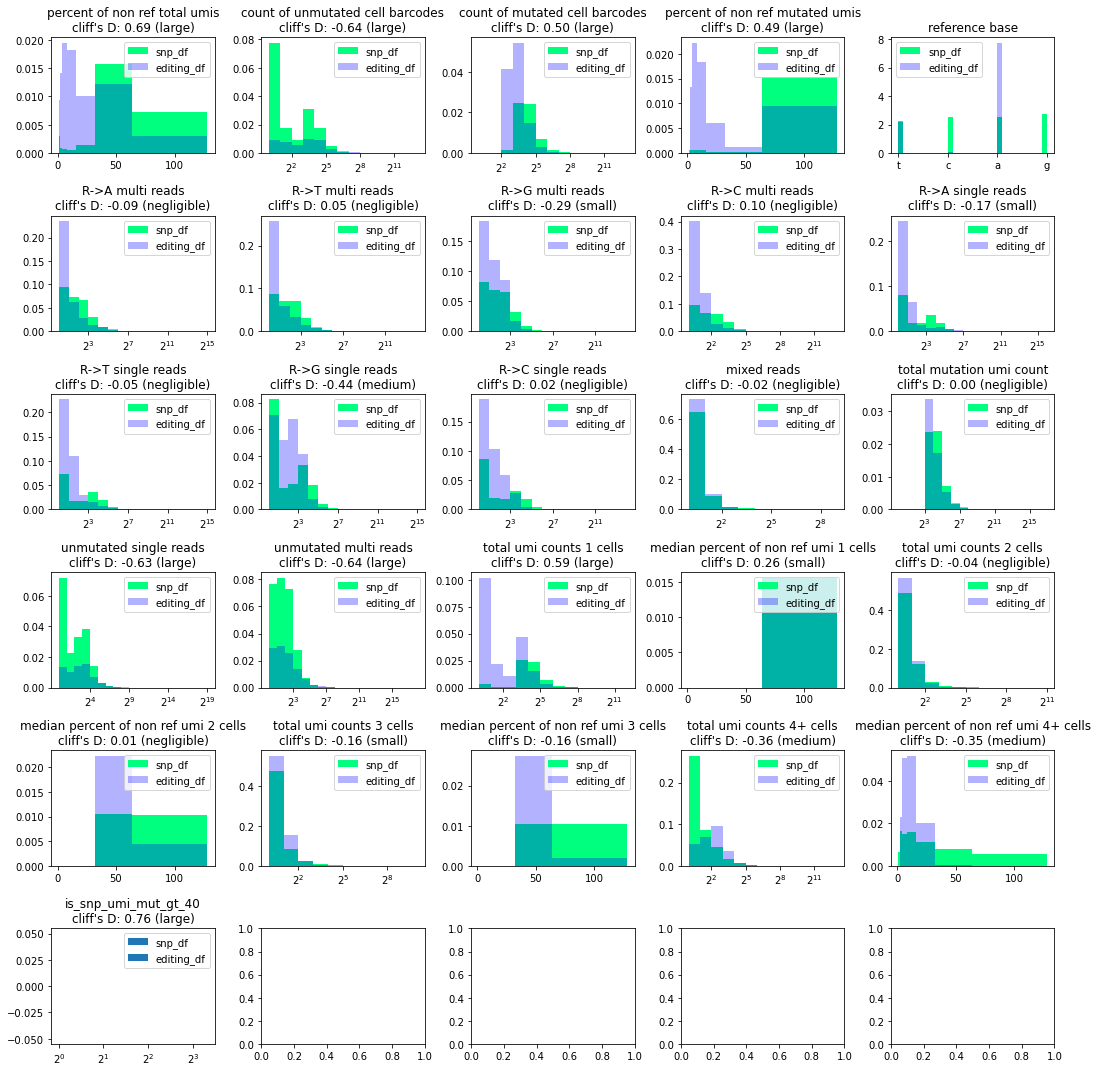

In [69]:
plot_histograms(df[df['is_snp']==1], df[(df['is_editing_rep'] ==1) | (df['is_editing_non_rep']==1)], ['snp_df', 'editing_df'])


# Histogram A for Dena - 

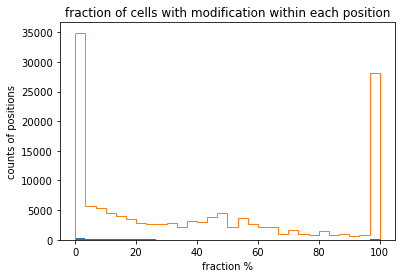

In [51]:
"""
this histogram is hist A for Dena. 
First, we calculated the fraction of cells with modification out of all the cells in this position. 
Next we choose all the positions with overlap with the editing database and plot a histogram for these fraction values.
"""
def Dena_hist1(df):
    # add to aggregated file a column with fraction of mutated cells out of total number of cells in a postoin 
    df['percent of mutated cells'] = df['count of mutated cell barcodes'] / (df['count of mutated cell barcodes'] + df['count of unmutated cell barcodes']) * 100
    df_edit = df[(df['is_editing_rep'] == 1) | (df['is_editing_non_rep'] == 1)] 

    plt.title("fraction of cells with modification within each position")
    plt.xlabel("fraction %")
    plt.ylabel("counts of positions")
    plt.hist(df_edit['percent of mutated cells'],bins=30)
    plt.hist(df['percent of mutated cells'],bins=30,histtype='step')
    plt.show()

In [39]:
"""
this histogram is hist A for Dena. 
First, we calculated the fraction of cells with modification out of all the cells in this position. 
Next we choose all the positions with overlap with the editing database and plot a histogram for these fraction values.
"""
def Dena_hist1(df):
    # add to aggregated file a column with fraction of mutated cells out of total number of cells in a postoin 
    df['percent of mutated cells'] = df['count of mutated cell barcodes'] / (df['count of mutated cell barcodes'] + df['count of unmutated cell barcodes']) * 100
    df_edit = df[(df['is_editing_rep'] == 1) | (df['is_editing_non_rep'] == 1)] 

    plt.title("fraction of cells with modification within each position")
    plt.xlabel("fraction %")
    plt.ylabel("counts of positions")
    plt.hist(df_edit['percent of mutated cells'],bins=30)
    plt.hist(df['percent of mutated cells'],bins=30,histtype='step')
    plt.show()

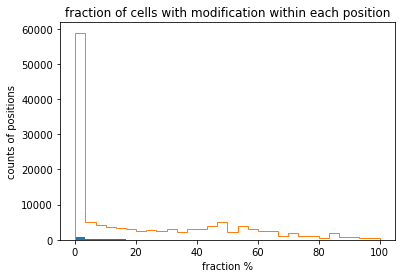

In [41]:
Dena_hist1(adipose_df)

# Hist B for Dena - Analyse data table in open form

In [48]:
def Dena_histb(df_open, df_agg):
    print("df_open original shape:", df_open.shape)
    # merge with agg df and transfer the edit-snp flags. The output shape is as df_open. Note that agg_df might be already filtered.
    df_open = df_open.merge(df_agg[['position','is_snp','is_editing_rep','is_editing_non_rep']],on = 'position')
    print("df_open shape after merge:", df_open.shape)
    # make subset of editing sites
    df_open_edit = df_open[(df_open['is_editing_rep'] == 1) | (df_open['is_editing_non_rep'] == 1)]  # set editing sites as positive label
    print("df_open only editing sites:", df_open_edit.shape)
    
    df_open_edit_gt1 = df_open_edit[df_open_edit['total umi count'] > 1]

    # look at UMI's fraction - mean and std for all cells within each position
    col = 'percent of non ref'
    df_grouped = df_open_edit_gt1.groupby(['position'])
    df_grouped_mean_std = pd.DataFrame(df_grouped.groups.keys(), columns = ['position'])
    df_grouped_mean_std['mean {}'.format(col)] = df_grouped[col].median().values
    df_grouped_mean_std['std {}'.format(col)] = df_grouped[col].std().values
    df_grouped_mean_std['number of cells with more than 1 UMI'] = df_grouped[col].count().values
    df_agg_extand = df_agg.merge(df_grouped_mean_std,on = 'position')
    
    # plot
    plt.hist(df_grouped_mean_std['mean percent of non ref'], bins = 20)
    plt.show()

In [74]:
df_open = pd.read_csv("/home/eligol/Documents/01_WIS/01_Rarevar/outputs/statistics_output/human_RSS9451/merged_mutated_unmutated_no_agg.tsv", sep='\t')
Dena_histb(df_open, embryo_df)

NameError: name 'Dena_histb' is not defined

df_open original shape: (6957946, 21)
df_open shape after merge: (2741933, 24)
df_open only editing sites: (47002, 24)


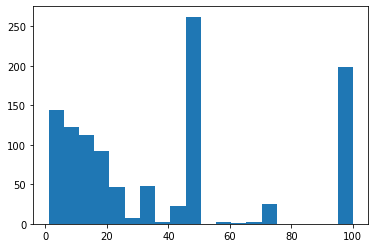

In [50]:
df_open = pd.read_csv("/home/eligol/Documents/01_WIS/01_Rarevar/outputs/statistics_output/human_adipose/from_wexac/merged_mutated_unmutated_no_agg.tsv", sep='\t')
Dena_histb(df_open, adipose_df)

In [134]:
df_open[df_open['position'] == 'chr10:1000771-1000772,+']
df_grouped_mean_std
df_open_edit['position'].nunique()
df_open.shape

(2070059, 24)

In [131]:
df_open_edit_gt1 = df_open_edit[df_open_edit['total umi count'] >= 0]
col = 'percent of non ref'
df_grouped = df_open_edit_gt1.groupby(['position'])
df_grouped_mean_std = pd.DataFrame(df_grouped.groups.keys(), columns = ['position'])
df_grouped_mean_std['mean {}'.format(col)] = df_grouped[col].median().values
df_grouped_mean_std['std {}'.format(col)] = df_grouped[col].std().values
df_grouped_mean_std['number of cells with more than 1 UMI'] = df_grouped[col].count().values
df_agg_extand = embryo_df.merge(df_grouped_mean_std,on = 'position')

In [132]:
df_agg_extand

#Chromosome      start        end                    position  \
0           chr1     634011     634012        chr1:634011-634012,+   
1           chr1     944306     944307        chr1:944306-944307,-   
2           chr1    7722876    7722877      chr1:7722876-7722877,+   
3           chr1    8777036    8777037      chr1:8777036-8777037,-   
4           chr1    9267967    9267968      chr1:9267967-9267968,+   
...          ...        ...        ...                         ...   
1338        chrX  129817893  129817894  chrX:129817893-129817894,-   
1339        chrX  129817894  129817895  chrX:129817894-129817895,-   
1340        chrX  129817903  129817904  chrX:129817903-129817904,-   
1341        chrX  136841385  136841386  chrX:136841385-136841386,-   
1342        chrY   19041906   19041907    chrY:19041906-19041907,-   

      percent of non ref total reads strand  count of unmutated cell barcodes  \
0                               0.11      +                              4113   
1                              99.39      -                                 2   
2                              50.00      +                                 5   
3                              16.13      -                                52   
4                              35.29      +                                11   
...                              ...    ...                               ...   
1338                           36.36      -                                21   
1339                           18.18      -                                27   
1340                           28.57      -                                25   
1341                           11.76      -                                44   
1342                           45.45      -                                 6   

      count of mutated cell barcodes  percent of non ref mutated reads  \
0                                 10                             32.26   
1                                314                            100.00   
2                                  5                            100.00   
3                                 10                            100.00   
4                                  6                            100.00   
...                              ...                               ...   
1338                              12                            100.00   
1339                               6                            100.00   
1340                              10                            100.00   
1341                               6                            100.00   
1342                               5                            100.00   

     reference base  R->A multi reads  R->T multi reads  R->G multi reads  \
0                 t                 0                 1                 0   
1                 a                 0                 0                49   
2                 a                 0                 0                 2   
3                 a                 0                 0                 5   
4                 a                 0                 0                 1   
...             ...               ...               ...               ...   
1338              a                 0                 0                 4   
1339              a                 0                 0                 1   
1340              a                 0                 0                 4   
1341              a                 0                 0                 2   
1342              a                 0                 0                 1   

      R->C multi reads  R->A single reads  R->T single reads  \
0                    0                  0                 20   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                

In [115]:
(df_open.groupby(['position']).filter(lambda x: x['cell barcode'].count() == 5))

Chromosome     start       end        cell barcode  \
372           chr8  73290666  73290667  AGTTGGTTCCACTGGG-1   
373           chr8  73290666  73290667  ATCCGAAAGCTACCGC-1   
374           chr8  73290666  73290667  GTGTTAGAGAACAACT-1   
375           chr8  73290666  73290667  GATCGTAGTTCTGAAC-1   
376           chr8  73290666  73290667  ATTTCTGCAATGGAGC-1   
...            ...       ...       ...                 ...   
2070048      chr11  62888631  62888632  GGTGCGTAGATCCCAT-1   
2070049      chr11  62888631  62888632  GGCCGATTCCTCTAGC-1   
2070050      chr11  62888631  62888632  GGAAAGCCATAGACTC-1   
2070051      chr11  62888631  62888632  ACTGAGTCACCCAGTG-1   
2070052      chr11  62888631  62888632  CTGCGGAGTTCGCGAC-1   

         percent of non ref strand reference base  R->A multi reads  \
372                      20      -              t                 0   
373                      11      -              t                 0   
374                      16      -              t                 0   
375                      20      -              t                 0   
376                      33      -              t                 0   
...                     ...    ...            ...               ...   
2070048                  10      +              t                 0   
2070049                  50      +              t                 0   
2070050                  16      +              t                 0   
2070051                   7      +              t                 0   
2070052                 100      +              t                 0   

         R->C multi reads  R->G multi reads  R->T multi reads  \
372                     0                 0                 0   
373                     0                 0                 1   
374                     0                 0                 0   
375                     0                 0                 0   
376                     0                 0                 1   
...                   ...               ...               ...   
2070048                 0                 1                 6   
2070049                 0                 0                 1   
2070050                 0                 0                 4   
2070051                 0                 0                 7   
2070052                 0                 0                 0   

         R->A single reads  R->C single reads  R->G single reads  \
372                      1                  0                  0   
373                      0                  1                  0   
374                      1                  0                  0   
375                      1                  0                  0   
376                      1                  0                  0   
...                    ...                ...                ...   
2070048                  0                  0                  0   
2070049                  0                  1                  0   
2070050                  0                  1                  0   
2070051                  0                  0                  1   
2070052                  0                  1                  0   

         R->T single reads  mixed reads                   position  \
372                      4            0   chr8:73290666-73290667,-   
373                      7            0   chr8:73290666-73290667,-   
374                      5            0   chr8:73290666-73290667,-   
375                      4            0   chr8:73290666-73290667,-   
376                      1            0   chr8:73290666-73290667,-   
...                    ...          ...                        ...   
2070048                  3            0  chr11:62888631-62888632,+   
2070049                  0            0  chr11:62888631-62888632,+   
2070050                  1            0  chr11:62888631-62888632,+   
2070051                  5            0  chr11:62888631-62888632,+   
2070052                  0            0  c

In [135]:
pd.read_csv('/home/eligol/Documents/01_WIS/01_Rarevar/outputs/statistics_output/human_SRR9451/aggregated_tsv.tsv',sep = '\t')

Chromosome     start       end                  position  \
0             chr1     14676     14677        chr1:14676-14677,-   
1             chr1     14677     14678        chr1:14677-14678,-   
2             chr1     14727     14728        chr1:14727-14728,-   
3             chr1     14730     14731        chr1:14730-14731,-   
4             chr1     14736     14737        chr1:14736-14737,-   
...            ...       ...       ...                       ...   
2387374       chrY  26524601  26524602  chrY:26524601-26524602,+   
2387375       chrY  26561925  26561926  chrY:26561925-26561926,+   
2387376       chrY  26561926  26561927  chrY:26561926-26561927,+   
2387377       chrY  26561937  26561938  chrY:26561937-26561938,+   
2387378       chrY  26561947  26561948  chrY:26561947-26561948,+   

         percent of non ref total reads strand  \
0                                 40.83      -   
1                                  0.75      -   
2                                  0.36      -   
3                                  0.35      -   
4                                  0.35      -   
...                                 ...    ...   
2387374                          100.00      +   
2387375                          100.00      +   
2387376                          100.00      +   
2387377                          100.00      +   
2387378                          100.00      +   

         count of unmutated cell barcodes  count of mutated cell barcodes  \
0                                    70.0                              49   
1                                   131.0                               1   
2                                   271.0                               1   
3                                   275.0                               1   
4                                   276.0                               1   
...                                   ...                             ...   
2387374                               0.0                               2   
2387375                               0.0                               1   
2387376                               0.0                               1   
2387377                               0.0                               1   
2387378                               0.0                               1   

         percent of non ref mutated reads reference base  R->A multi reads  \
0                                    98.0              c                 0   
1                                   100.0              t                 0   
2                                   100.0              g                 0   
3                                   100.0              c                 0   
4                                   100.0              c                 0   
...                                   ...            ...               ...   
2387374                             100.0              t                 1   
2387375                             100.0              t                 0   
2387376                             100.0              g                 0   
2387377                             100.0              t                 0   
2387378                             100.0              t                 0   

         R->T multi reads  R->G multi reads  R->C multi reads  \
0                       2                 0                 0   
1                       0                 0                 0   
2                       0                 0                 0   
3                       0                 0                 0   
4                       0                 0                 0   
...                   ...               ...               ...   
2387374                 0                 0                 0   
2387375                 0                 0                 0   
2387376                 0                 0                 0   
2387377                 0                 0                 0   
2387378      

In [96]:
t[t != 0]

Series([], dtype: int64)

In [36]:
# add column of mean and std of all cell barcodes in each position
cols = [col for col in embryo_df.columns if col.startswith("R->")]
cols = cols + ['total umi count']
df_grouped = df_open.groupby('position')
df_temp = pd.DataFrame(df_grouped.groups.keys(),columns = ['position'])
for col in cols:
    df_temp['mean {}'.format(col)] = df_grouped[col].mean().values
    df_temp['std {}'.format(col)] = df_grouped[col].std().values
df_agg_extand = embryo_df.merge(df_temp,on = 'position')

# # add edit and snp notation to df (not aggregated)
# for col in ['is_snp', 'is_editing_rep', 'is_editing_non_rep']:
#     positions = df_agg_extand.loc[df_agg_extand[col] == 1, 'position'].values
#     df[col] = 0
#     df.loc[df['position'].isin(positions), col] = 1


## K-means

In [ ]:
#KMEANS
kmeans = KMeans(n_clusters=2, n_init = 100, max_iter = 10000)
t = kmeans.fit_predict(df_numeric)

confusion_matrix(df['label'].values,t)

## PCA

PC explained variance: [0.96036923 0.03277084]


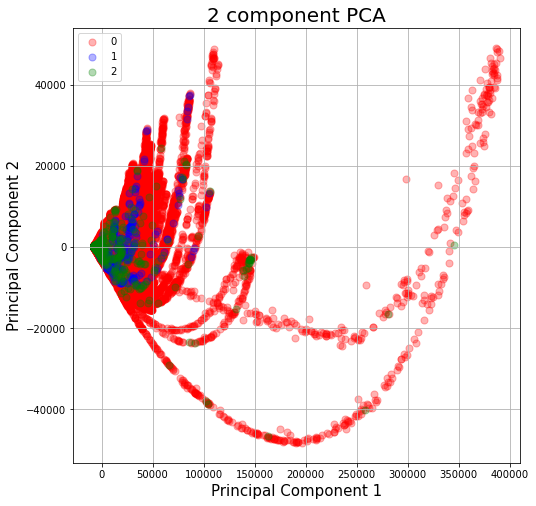

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_numeric)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['label']].reset_index()], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color, alpha = 0.3
               , s = 50)
ax.legend(targets)
ax.grid()
print("PC explained variance:",pca.explained_variance_ratio_)
plt.show()

# TSNE

In [7]:
# set data to analyze - all numeric data
X = df_numeric

# run TSNE on all numeric data 
tsne = TSNE(n_components = 2,n_jobs=-1,perplexity = 30)
X_embedded = tsne.fit_transform(X)

In [8]:
X_embedded.shape

(108700, 2)

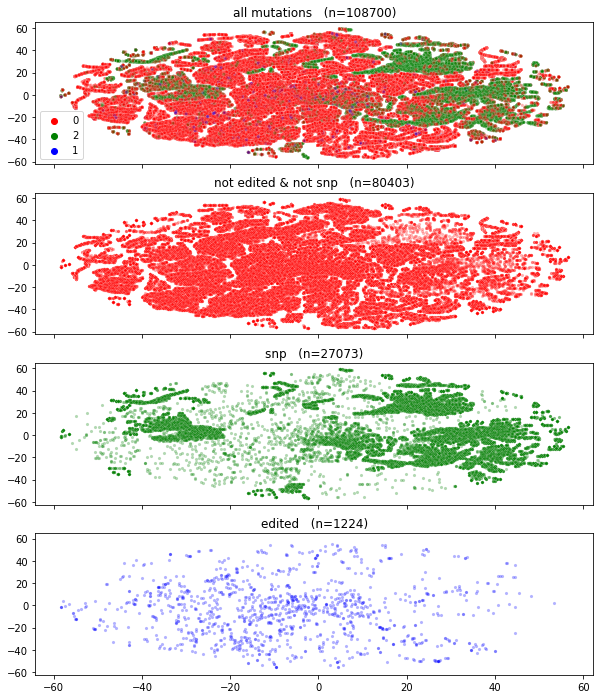

In [9]:
# plot TSNE 
y = df[['label']].values.reshape((df.shape[0],))

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 12),sharex=True, sharey=True)
axs = axs.reshape(-1)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1],s=10,alpha = 0.3,palette=['red','green','blue'],hue=y,hue_order=[0,2,1],ax=axs[0])
axs[0].set_title("all mutations   (n={})".format(str(len(y))))
sns.scatterplot(x=X_embedded[y==0,0], y=X_embedded[y==0,1],s=10,alpha = 0.3 ,color = 'red', legend='full',ax=axs[1])
axs[1].set_title("not edited & not snp   (n={})".format(str((y==0).sum())))
sns.scatterplot(x=X_embedded[y==2,0], y=X_embedded[y==2,1],s=10,alpha = 0.3, color = 'green', legend='full',ax=axs[2])
axs[2].set_title("snp   (n={})".format(str((y==2).sum())))
sns.scatterplot(x=X_embedded[y==1,0], y=X_embedded[y==1,1],s=10,alpha = 0.3, color = 'blue', legend='full',ax=axs[3])
axs[3].set_title("edited   (n={})".format(str((y==1).sum())))
plt.show()

#### plot TSNE - all numeric data by ref bases

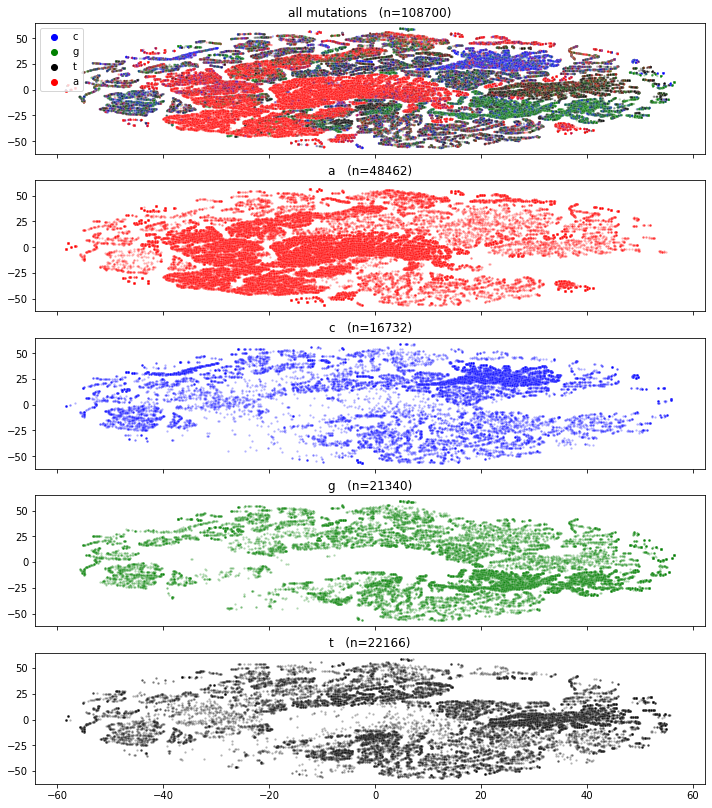

In [10]:
y = df[['reference base']].values.reshape((df.shape[0],))

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 14),sharex=True, sharey=True)
axs = axs.reshape(-1)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1],s =5,alpha = 0.3,hue=y,palette=['blue','green','black','red'],ax=axs[0])
axs[0].set_title("all mutations   (n={})".format(str(len(y))))
sns.scatterplot(x=X_embedded[y=='a',0], y=X_embedded[y=='a',1],s=5,alpha = 0.3,color = 'red', legend='full',ax=axs[1])
axs[1].set_title("a   (n={})".format(str((y=='a').sum())))
sns.scatterplot(x=X_embedded[y=='c',0], y=X_embedded[y=='c',1],s=5,alpha = 0.3, color = 'blue', legend='full',ax=axs[2])
axs[2].set_title("c   (n={})".format(str((y=='c').sum())))
sns.scatterplot(x=X_embedded[y=='g',0], y=X_embedded[y=='g',1],s=5,alpha = 0.3, color = 'green', legend='full',ax=axs[3])
axs[3].set_title("g   (n={})".format(str((y=='g').sum())))
sns.scatterplot(x=X_embedded[y=='t',0], y=X_embedded[y=='t',1],s=5,alpha = 0.3, color = 'black', legend='full',ax=axs[4])
axs[4].set_title("t   (n={})".format(str((y=='t').sum())))
plt.show()

## TSNE by ref after removing refbases

In [11]:
# set data to analyze - all numeric data without refbases
X = df_numeric.drop(['refbase_a','refbase_c','refbase_g','refbase_t'],axis=1)

# run TSNE
tsne = TSNE(n_components = 2,perplexity = 30,n_jobs=-1)
X_embedded_by_refbase = tsne.fit_transform(X)

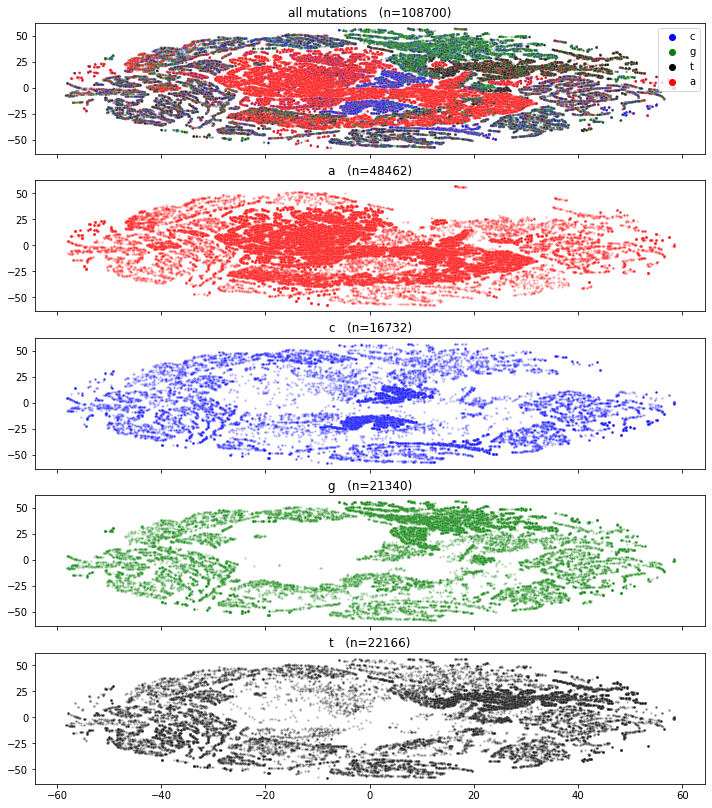

In [12]:
# plot TSNE by ref bases
y = df[['reference base']].values.reshape((df.shape[0],))

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 14),sharex=True, sharey=True)
axs = axs.reshape(-1)

sns.scatterplot(x=X_embedded_by_refbase[:,0], y=X_embedded_by_refbase[:,1],s =5,alpha = 0.3,hue=y,palette=['blue','green','black','red'],ax=axs[0])
axs[0].set_title("all mutations   (n={})".format(str(len(y))))
sns.scatterplot(x=X_embedded_by_refbase[y=='a',0], y=X_embedded_by_refbase[y=='a',1],s=5,alpha = 0.3,color = 'red', legend='full',ax=axs[1])
axs[1].set_title("a   (n={})".format(str((y=='a').sum())))
sns.scatterplot(x=X_embedded_by_refbase[y=='c',0], y=X_embedded_by_refbase[y=='c',1],s=5,alpha = 0.3, color = 'blue', legend='full',ax=axs[2])
axs[2].set_title("c   (n={})".format(str((y=='c').sum())))
sns.scatterplot(x=X_embedded_by_refbase[y=='g',0], y=X_embedded_by_refbase[y=='g',1],s=5,alpha = 0.3, color = 'green', legend='full',ax=axs[3])
axs[3].set_title("g   (n={})".format(str((y=='g').sum())))
sns.scatterplot(x=X_embedded_by_refbase[y=='t',0], y=X_embedded_by_refbase[y=='t',1],s=5,alpha = 0.3, color = 'black', legend='full',ax=axs[4])
axs[4].set_title("t   (n={})".format(str((y=='t').sum())))
plt.show()